In [1]:
from utils import *
import pandas as pd

In [2]:
df = pd.read_csv("final/autodoc_result.csv")
test = df[(df["extraction_result"] == 1) & (df["validation_result"] == 1)]
print(len(test))

143


In [11]:
df = pd.read_csv("final/autodoc_result.csv")
llm_baseline(df, gpt4, "autodoc_without_summarization")

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,api,language,knowledge_type,post_id,post,label,contain_knowledge,extracted_knowledge,extraction_result,validation_result
0,0,0,0,0,0,MessageDigest,Java,functionality,74682875,<p>If you're going to use the simplest JMS pat...,No. The post does not contain functionality kn...,0,No such knowledge,0,0
1,1,1,1,1,1,MessageDigest,Java,functionality,75890236,<p>First of all - MessageId is array of 24 byt...,No. The post does not contain functionality kn...,0,No such knowledge,0,0
2,2,2,2,2,2,MessageDigest,Java,functionality,74448585,<p>If <code>message1</code> and <code>message2...,"No, the post does not contain functionality kn...",0,No such knowledge,0,0
3,3,3,3,3,3,MessageDigest,Java,functionality,77230698,<p>You can use inner class for MessageSender:<...,"No, the post does not contain functionality kn...",0,No such knowledge,0,0
4,4,4,4,4,4,MessageDigest,Java,functionality,75892592,<p>How does Log4j 2.x interpret the <code>(Str...,No. \n\nThe provided post focuses on the use o...,0,No such knowledge,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,835,835,835,835,835,ByteArray,Kotlin,alternative,64852886,<p>The following is an object serializable cla...,"No, the post does not contain alternative know...",0,No such knowledge,0,0
836,836,836,836,836,836,ByteArray,Kotlin,alternative,55416646,<p>The easiest way is to use </p>\n\n<pre><cod...,"Yes, the post contains alternative knowledge a...",1,No such knowledge,0,0
837,837,837,837,837,837,ByteArray,Kotlin,alternative,65199270,<p>The easiest way to make a <code>ByteArray</...,"No, the post does not contain alternative know...",0,No such knowledge,0,0
838,838,838,838,838,838,ByteArray,Kotlin,alternative,76830156,<p>Kotlin 1.9 introduced experimental <a href=...,"No, the post does not contain alternative know...",0,No such knowledge,0,0


In [ ]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd


def llm_baseline(df, llm, model_name, start_index=-1):
    knowledge_type_descriptions = {
        "functionality": "describes the actions or operations an API can perform. For example, an functionality knowledge for tf.gather could be: 'tf.gather is used to select tensor elements at specific indices.'",
        "concept": "covers the foundational ideas and terminologies for understanding and effectively utilizing an API. For example, a concept knowledge for tf.gather could be: 'Tensor is essentially a high-dimensional array.'",
        "performance": "refers to the time and memory efficiency of an API. For example, a performance knowledge for tf.gather could be: 'tf.gather has overhead when used on large tensors.'",
        "directive": "is an essential type of knowledge that provides guidelines on the proper use of an API, including best practices to follow and actions to avoid. For example, a directive knowledge for tf.gather could be: 'When using tf.gather, ensure indices are within the shape of the input tensor.'",
        "pattern": "illustrates common use cases for applying the API to solve specific problems or achieve certain outcomes. For example, a pattern knowledge for tf.gather could be: 'tf.gather is commonly used in embedding lookup operations.'",
        "environment": "specifies the necessary conditions, system requirements, or configurations under which an API can function correctly. For example, an environment knowledge for tf.gather could be: 'tf.gather requires TensorFlow installed and supports both CPU and GPU execution.'",
        "alternative": "suggests other APIs offering similar functionality, which can be considered as replacements or complementary options. For example, an alternative knowledge for tf.gather could be: 'Alternatives to tf.gather include tf.scatter_nd and tf.index_select.'",
    }

    def extract_knowledge(row):
        api = row["api"]
        language = row["language"]
        key = api + "_" + language
        knowledge_type = row["knowledge_type"]
        post = row["post"]
        knowledge_type_explanation = knowledge_type_descriptions[knowledge_type]

        extraction_prompt = f"Extract {knowledge_type} knowledge of {api} (a class in {language}) from this post, including knowledge that you can infer from this post. {knowledge_type} {knowledge_type_explanation}. If the post does not contain such knowledge, reply 'No such knowledge' and nothing more. \n Post: {post}"

        return llm(extraction_prompt)

    extraction_result = []

    with ThreadPoolExecutor() as executor:
        results = list(
            tqdm(
                executor.map(extract_knowledge, (row for _, row in df.iterrows())),
                total=len(df),
                desc="Extracting knowledge from each post...",
            )
        )
        extraction_result.extend(results)

    df["extracted_knowledge"] = extraction_result
    df["extraction_result"] = [
        1 if i.lower().find("no such knowledge") == -1 else 0 for i in extraction_result
    ]

    def validate_knowledge(row):
        api = row["api"]
        language = row["language"]
        extracted_each_post = row["extracted_knowledge"]
        post = row["post"]

        if row["extraction_result"] == 1:
            validation_prompt = f'Can this knowledge of {api} (a class in {language}) be extracted from this post? If so, reply "Yes". If not, reply "No". Just reply "Yes" or "No".'
            validation_prompt += f"\nKnowledge: {extracted_each_post}"
            validation_prompt += f"\nPost: {post}"

            return llm(validation_prompt)
        else:
            return ""

    validation_result = []

    with ThreadPoolExecutor() as executor:
        # 使用 map 保证顺序
        results = list(
            tqdm(
                executor.map(validate_knowledge, (row for _, row in df.iterrows())),
                total=len(df),
                desc="Validating knowledge...",
            )
        )

        validation_result.extend(results)

    df["validation_result"] = [
        1 if i.lower().find("yes") != -1 else 0 for i in validation_result
    ]

    df.to_csv(f"final/{model_name}_result.csv")

    benchmark = list(set(df["api"].tolist()))

    def process_api(api):
        related_posts = df[df["api"] == api]
        all_knowledge = ""
        for index, row in related_posts.iterrows():
            if row["extraction_result"] == 1 and row["validation_result"] == 1:
                # if row["extraction_result"] == 1:
                all_knowledge += row["extracted_knowledge"] + "\n"

        # prompt = "Summarize these knowledge snippets into an API document, be concise but don't miss any knowledge. Put these knowledge snippets into seven sections, functionality, concept, pattern, performance, alternative, environment, directive."
        # prompt += "\n" + all_knowledge

        # generated_document = llm(prompt)

        generated_document = all_knowledge

        output_dir = "final/baseline_results"
        os.makedirs(output_dir, exist_ok=True)

        with open(f"{output_dir}/{model_name}_{api}.txt", "w") as f:
            f.write(generated_document)

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_api, api) for api in benchmark]

    for future in futures:
        future.result()

    return df


def write_to_txt(model_name):
    filename = f"baseline_results/{model_name}_result.csv"
    df = pd.read_csv(filename)
    df = df.fillna("")

    target_folder_path = f"baseline_results/{model_name}"

    all_apis = list(set(df["api"].tolist()))
    all_knowlege_types = list(set(df["knowledge_type"].tolist()))

    def find_section_knowledge(api, knowledge_type):
        return df[(df["api"] == api) & (df["knowledge_type"] == knowledge_type)][
            "summarization_result"
        ].tolist()[0]

    def find_language(api):
        return df[df["api"] == api]["language"].tolist()[0]

    for api in all_apis:
        result = ""
        language = find_language(api)

        for knowledge_type in all_knowlege_types:
            result += f"# {knowledge_type.capitalize()} Section\n"
            result += find_section_knowledge(api, knowledge_type) + "\n\n"

        with open(f"{target_folder_path}/{api}_{language}.md", "w") as f:
            f.write(result)

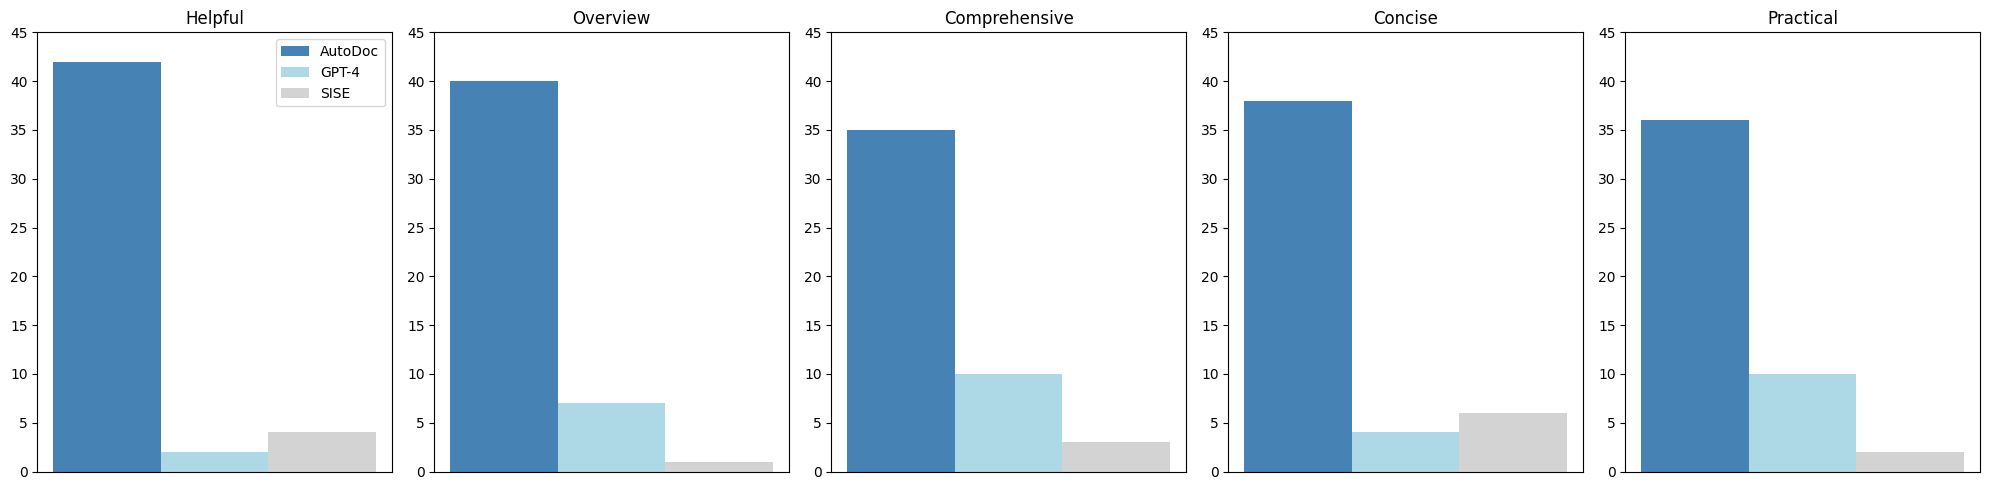

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

categories = ["Helpful", "Overview", "Comprehensive", "Concise", "Practical"]
autodoc = [42, 40, 35, 38, 36]
gpt4 = [2, 7, 10, 4, 10]
sise = [4, 1, 3, 6, 2]

bar_width = 0.25
index = np.arange(len(categories))

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, ax in enumerate(axes):
    ax.bar(index[i], autodoc[i], bar_width, label="AutoDoc", color="steelblue")
    ax.bar(index[i] + bar_width, gpt4[i], bar_width, label="GPT-4", color="lightblue")
    ax.bar(
        index[i] + 2 * bar_width, sise[i], bar_width, label="SISE", color="lightgray"
    )

    ax.set_title(categories[i])
    ax.set_xticks([])
    ax.set_ylim(0, 45)

axes[0].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [48]:
df = pd.read_csv("related_posts.csv")
df.head()

,api,language,knowledge_type,post_id,post
0,ByteArray,Kotlin,functionality,56185257,<p><code>ByteArray</code> is an object (refere...
1,ByteArray,Kotlin,functionality,76830156,<p>Kotlin 1.9 introduced experimental <a href=...
2,ByteArray,Kotlin,functionality,60844731,<p>You can use <code>String(byteArray)</code> ...
3,ByteArray,Kotlin,functionality,67229929,<p>Here is the solution.</p>\n<p><strong>Int -...
4,ByteArray,Kotlin,functionality,65427627,<p><code>byteArray.toString()</code> is used t...


#### LLM-based baselines, e.g., AutoDoc, substituting gpt4 to llama2 or llama3.


In [25]:
llam3_result = llm_baseline(df, llama3_70b_instruct, "llama3_70b_instruct")
llama2_result = llm_baseline(df, llama2_70b_chat, "llama2_70b_chat")
mistral_result = llm_baseline(df, mistral_7b_instruct_v3, "mistral")

In [43]:
write_to_txt("mistral")
write_to_txt("llama2_70b_chat")
write_to_txt("llama3_70b_instruct")

#### Non-LLM baselines, i.e., SISE and API caveat.


In [ ]:
! pip install spacy
! python -m spacy download en_core_web_sm

In [ ]:
import re
import spacy
from bs4 import BeautifulSoup


def api_caveat(post):
    nlp = spacy.load("en_core_web_sm")

    caveat_patterns = {
        "Error/Exception": [
            "insecure",
            "susceptible",
            "error",
            "null",
            "exception",
            "unavailable",
            "not thread safe",
            "illegal",
            "inappropriate",
            "insecure",
        ],
        "Recommendation": [
            "deprecate",
            "better to",
            "best to",
            "recommended",
            "less desirable",
            "discourage",
        ],
        "Alternative": ["instead of", "rather than", "otherwise"],
        "Imperative": ["do not"],
        "Note": ["note that", "notably", "caution"],
        "Conditional": ["under the condition", "whether", "if", "when", "assume that"],
        "Temporal": ["before", "after"],
        "Affirmative": ["must", "should", "have to", "need to"],
        "Negative": ["do not", "be not", "never"],
        "Emphasis": ["none", "only", "always"],
    }

    def find_caveat_sentences(post):
        doc = nlp(post)
        caveat_sentences = []

        for sent in doc.sents:
            sentence = sent.text
            for category, patterns in caveat_patterns.items():
                for pattern in patterns:
                    if re.search(
                        r"\b" + re.escape(pattern) + r"\b", sentence, re.IGNORECASE
                    ):
                        caveat_sentences.append(sentence)
                        break
        return caveat_sentences

    caveat_sentences = find_caveat_sentences(post)
    caveat_sentences = [i.strip() for i in list(set(caveat_sentences))]

    return caveat_sentences

In [ ]:
def non_llm_baselines(df, baseline, model_name):
    def remove_html_tags(post):
        soup = BeautifulSoup(post, "html.parser")
        for pre_tag in soup.find_all("pre"):
            pre_tag.decompose()
        return soup.get_text()

    target_folder_path = "final/baseline_results"

    all_apis = list(set(df["api"].tolist()))

    def find_language(api):
        return df[df["api"] == api]["language"].tolist()[0]

    for api in all_apis:
        language = find_language(api)
        snippets = []
        for _, row in df[df["api"] == api].iterrows():
            post = remove_html_tags(row["post"])

            snippets += [i.strip() for i in baseline(post)]
        snippets = [f"{index}. " + i for index, i in enumerate(list(set(snippets)))]

        to_write = "\n".join(snippets)

        with open(f"{target_folder_path}/{model_name}_{api}.txt", "w") as f:
            f.write(to_write)

In [4]:
df = pd.read_csv("finetuned_retrieved_posts.csv")

In [9]:
non_llm_baselines(df, api_caveat, "api_caveat")